## dropout 

1. 模型应该对输入数据的扰动鲁棒
   - 使用有噪音的数据等价于 Tikhonov 正则
  
2. 丢弃法，在层之间加入噪音。但是层的期望没有发生变化
   - 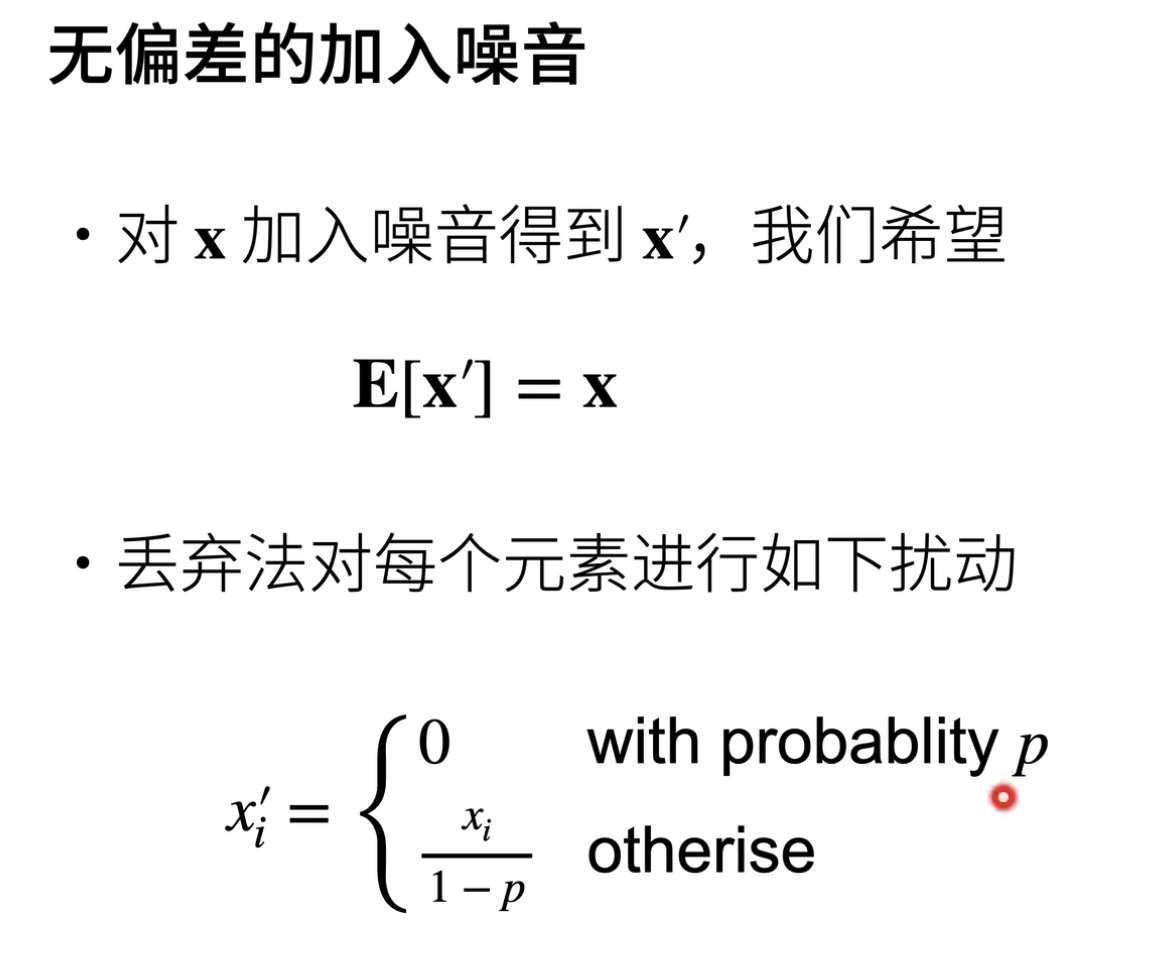
  
   - 通常用在隐藏全连接层的输出上
   - 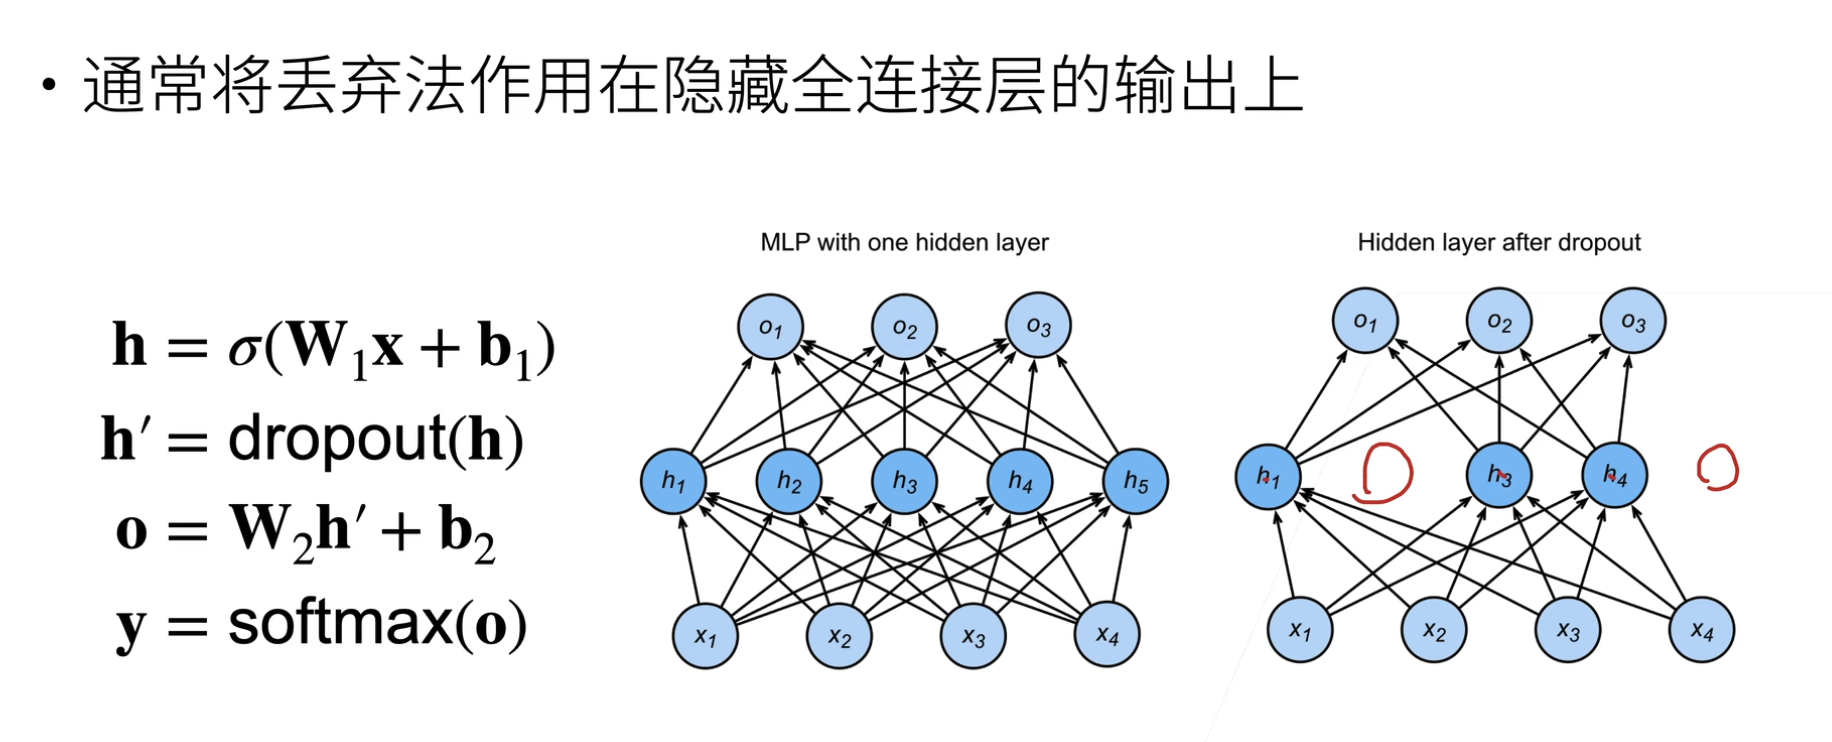
  
   - 仅在训练的时候使用，在推理的时候直接返回所有的输出
   - 丢弃的概率是控制模型复杂度的超参数


In [12]:
import torch
from torch import nn 
from d2l import torch as d2l 

def dropout_layer(x, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(x)
    if dropout == 0:
        return x
    
    mask = (torch.randn(x.shape) > dropout).float()
    return mask * x / (1.0 - dropout)    # GPU 算乘法很快

In [13]:
x = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(x)
print(dropout_layer(x, 0.))
print(dropout_layer(x, 0.5))
print(dropout_layer(x, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  0.,  0., 10.,  0.,  0.],
        [ 0.,  0.,  0., 22., 24.,  0., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [14]:
dropout1, dropout2 = 0, 0

# *args 接收 任意数量的无关键字参数，传入参数存储为元组
# **kwargs 接收任意数量的 有关键字的参数，传入参数存储为字典
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training = True):
        # 继承父类的初始化 Net的父类是nn.Module
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        H1 = self.relu(self.lin1(x.reshape((-1, self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)

        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)

        out = self.lin3(H2)
        return out


In [15]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

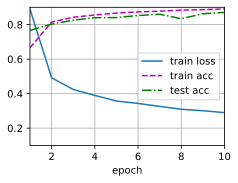

In [16]:
num_epochs, lr, batch_size = 10, 0.5, 256

loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [17]:
# 简洁实现

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

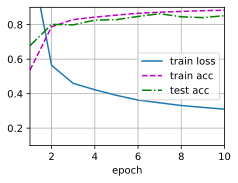

In [18]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)